# Proxy Composites using CFR package

Let's create proxy composites from the PAGES2k database using the GraphDB.

In [16]:
import json
import requests
import pandas as pd
import io
import numpy as np
import cfr as cfr

## PAGES2k

### Query the GraphDB for the temperature sensitive timeseries from PAGES2k

PAGES2k identified temperature-sensitive records through the property `useInGlobalTemperatureAnalysis` so we will make the query through this property. 

Other pieces of metadata are important for the cfr package. The query needs to include the following items:

* dataset name
* pages2kid (used to filter)
* latitute
* longitude
* archive
* proxy (ProxyObservation in LinkedEarth Ontology -> this property/class also needs to be attached to inferred variable now)
* variable name
* varibale units (can be NaN)
* time units
* Value for time
* Variable values

In [15]:
url = 'https://linkedearth.graphdb.mint.isi.edu/repositories/LiPDVerse'

query = """PREFIX le: <http://linked.earth/ontology#>
select ?dsname ?val ?timeval ?archive ?pages2kID ?timeunits ?varname ?varunits ?lat ?lon ?alt ?proxysensor ?proxyobs ?timevarname FROM <http://linked.earth/lipd/Pages2k2_1_2> where { 
	VALUES ?timevarname {"year" "age"}
    ?ds  le:includesPaleoData ?data .
    ?ds le:name ?dsname .
    ?ds  le:collectedFrom ?loc .
    ?loc le:wgs84_Lat ?lat .
    ?loc le:wgs84_Long ?lon .
    OPTIONAL{?loc le:wgs84_Alt ?alt .}
	?data le:foundInMeasurementTable ?table .
	?table le:includesVariable ?var .
    ?var le:useInGlobalTemperatureAnalysis true .
    ?var le:hasValues ?val .
    ?var le:name ?varname . 
    OPTIONAL{?var le:hasUnits ?varunits .}
    ?table le:includesVariable ?timevar .
    ?timevar le:name ?timevarname .
    ?timevar le:hasValues ?timeval .
    ?ds le:proxyArchiveType ?archive .
    OPTIONAL{?timevar le:hasUnits ?timeunits .}
    ?var le:hasProxySystem ?proxysystem .
    OPTIONAL{?proxysystem le:proxySensorType ?proxysensor .}
    ?proxysystem le:proxyObservationType ?proxyobs .
    ?var le:pages2kID ?pages2kID .
}"""


response = requests.post(url, data = {'query': query})
data = io.StringIO(response.text)
df = pd.read_csv(data, sep=",")

# Make list from the values string
df['val']=df['val'].apply(lambda row : np.fromstring(row.strip("[]"), sep=','))
df['timeval']=df['timeval'].apply(lambda row : np.fromstring(row.strip("[]"), sep=','))

df

dsname  \
0               Ant-WDC05A.Steig.2013   
1             NAm-MtLemon.Briffa.2002   
2         Arc-Arjeplog.Bjorklund.2014   
3                 Asi-CHIN019.Li.2010   
4          NAm-Landslide.Luckman.2006   
..                                ...   
574             Asi-CHIN066.Shao.2013   
575        NAm-OregonCaves.Ersek.2012   
576    Aus-DuckholeLake.Saunders.2013   
577         Ant-TaylorDome.Steig.2000   
578  Arc-AkademiiNaukIceCap.Opel.2013   

                                                   val  \
0    [-33.32873325, -35.6732, -33.1574, -34.2854, -...   
1    [0.968, 0.962, 1.013, 0.95, 1.008, 0.952, 1.02...   
2    [-0.829089212152348, -0.733882889924006, -0.89...   
3    [1.465, 1.327, 1.202, 0.757, 1.094, 1.006, 1.2...   
4    [1.123, 0.841, 0.863, 1.209, 1.139, 1.056, 0.8...   
..                                                 ...   
574  [1.468, 1.296, 1.445, 1.381, 1.298, 0.906, 0.8...   
575  [-8.747, -8.619, -8.686, -8.618, -8.695, -8.63...   
576  [0.17358, 0.15316, 0.16733, 0.177, 0.17133, 0....   
577  [-38.98, -35.87, -39.19, nan, -38.85, -37.4, -...   
578  [-19.2599, -22.1392, -20.3402, -18.7155, -17.4...   

                                               timeval        archive  \
0    [2005.0, 2004.0, 2003.0, 2002.0, 2001.0, 2000....    glacier ice   
1    [1568.0, 1569.0, 1570.0, 1571.0, 1572.0, 1573....           tree   
2    [1200.0, 1201.0, 1202.0, 1203.0, 1204.0, 1205....           tree   
3    [1509.0, 1510.0, 1511.0, 1512.0, 1513.0, 1514....           tree   
4    [913.0, 914.0, 915.0, 916.0, 917.0, 918.0, 919...           tree   
..                                                 ...            ...   
574  [1374.0, 1375.0, 1376.0, 1377.0, 1378.0, 1379....           tree   
575  [234.0, 237.0, 239.0, 241.0, 243.0, 246.0, 248...     speleothem   
576  [-51.32076, -48.12505, -45.38269, -43.17414, -...  lake sediment   
577  [12.9000000000001, 15.2, 17.3, 19.5, 21.7, 23....    glacier ice   
578  [-0.048, -0.047, -0.046, -0.045, -0.044, -0.04...    glacier ice   

    pages2kID timeunits      varname varunits      lat       lon     alt  \
0     Ant_006        AD         d18O   permil -79.4600 -112.0900  1806.0   
1     NAm_107        AD          MXD      NaN  32.5000 -110.8000  2700.0   
2     Arc_065        AD      density      NaN  66.3000   18.2000   800.0   
3     Asi_041        AD        trsgi      NaN  29.1500   99.9300  2150.0   
4     NAm_032        AD        trsgi      NaN  60.2000 -138.5000   800.0   
..        ...       ...          ...      ...      ...       ...     ...   
574   Asi_100        AD        trsgi      NaN  33.7200   96.2800  3500.0   
575   NAm_079        BP         d18O   permil  42.0830 -123.4160  1200.0   
576   Aus_029        BP  RABD660_670      NaN -43.3646  146.8749   150.0   
577   Ant_023        BP         d18O   permil -77.7800  158.7200  2365.0   
578   Arc_064        BP         d18O   permil  80.5200   94.8200   750.0   

                   proxysensor      proxyobs timevarname  
0            D18ODefaultSensor          D18O        year  
1             MXDDefaultSensor           MXD        year  
2    DeltaDensityDefaultSensor  DeltaDensity        year  
3             TRWDefaultSensor           TRW        year  
4             TRWDefaultSensor           TRW        year  
..                         ...           ...         ...  
574           TRWDefaultSensor           TRW        year  
575          D18ODefaultSensor          D18O         age  
576   ReflectanceDefaultSensor   Reflectance         age  
577          D18ODefaultSensor          D18O         age  
578          D18ODefaultSensor          D18O         age  

[579 rows x 14 columns]

### Create a ProxyDatabase with cfr

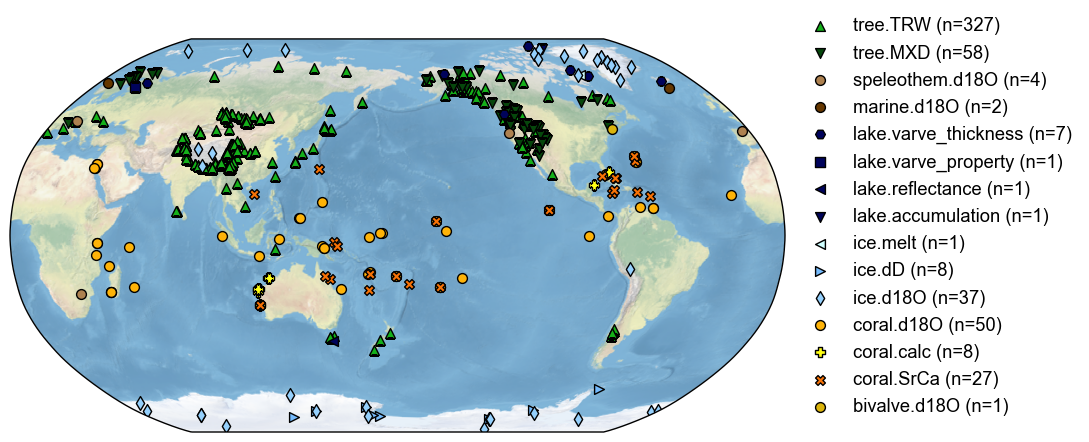

In [17]:
pdb = cfr.ProxyDatabase().from_df(df,
                                  pid_column='dsname',
                                  lat_column='lat',
                                  lon_column='lon',
                                  time_column='timeval',
                                  value_column='val',
                                  proxy_type_column='proxyobs',
                                  archive_type_column='archive',
                                  value_name_column='varname',
                                  value_unit_column='varunits')
                                  
fig, ax = pdb.plot()

### Create a composite for each archivetype

#### Calibrate against instrumental data

First, create a list of the possible archive types stored in the ProxyDataBase

In [18]:
type_list = pdb.type_list
proxy_type = []

for i in type_list:
    if i.split('.')[0] in proxy_type:
        pass
    else:
        proxy_type.append(i.split('.')[0])

Load instrumental temperature observations as a target for scaling the proxy values.

In [19]:
import xarray as xr

ds = xr.open_dataset('./data/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc')
ds

<xarray.Dataset>
Dimensions:           (time: 2071, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time              (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-07-1...
  * latitude          (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude         (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
    realization       int64 ...
Dimensions without coordinates: bnds
Data variables:
    tas_mean          (time, latitude, longitude) float64 ...
    time_bnds         (time, bnds) datetime64[ns] ...
    latitude_bnds     (latitude, bnds) float64 ...
    longitude_bnds    (longitude, bnds) float64 ...
    realization_bnds  (bnds) int64 ...
Attributes:
    comment:      2m air temperature over land blended with sea water tempera...
    history:      Data set built at: 2022-09-06T13:35:49+00:00
    institution:  Met Office Hadley Centre / Climatic Research Unit, Universi...
    licence:      HadCRUT5 is licensed under the Open Government Licence v3.0...
    reference:    C. P. Morice, J. J. Kennedy, N. A. Rayner, J. P. Winn, E. H...
    source:       CRUTEM.5.0.1.0 HadSST.4.0.0.0
    title:        HadCRUT.5.0.1.0 blended land air temperature and sea-surfac...
    version:      HadCRUT.5.0.1.0
    Conventions:  CF-1.7

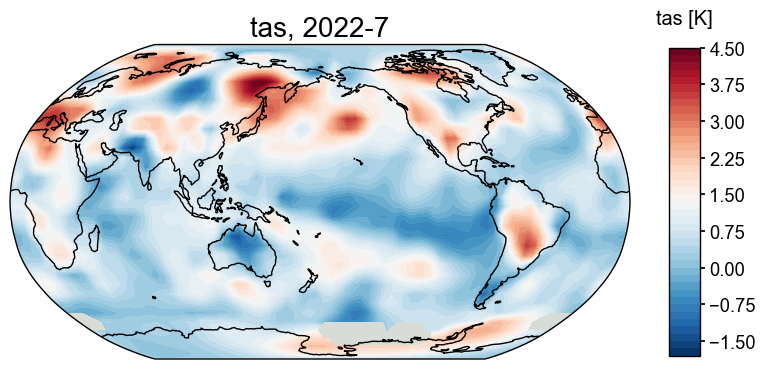

In [22]:
obs = cfr.ClimateField().load_nc(
    './data/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc',
    vn='tas_mean', lat_name='latitude', lon_name='longitude',
)
obs = obs.rename('tas')
fig, ax = obs.plot(it=-1) #(optional plot, just making sure it's the right data; i.e. interpolated grid)

##### Create a reconstruction for each archive type

Analyzing ProxyRecord:   7%|█▎                   | 3/46 [00:00<00:01, 29.43it/s]/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Analyzing ProxyRecord:  20%|████                 | 9/46 [00:00<00:00, 44.99it/s]/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/lib/function_b

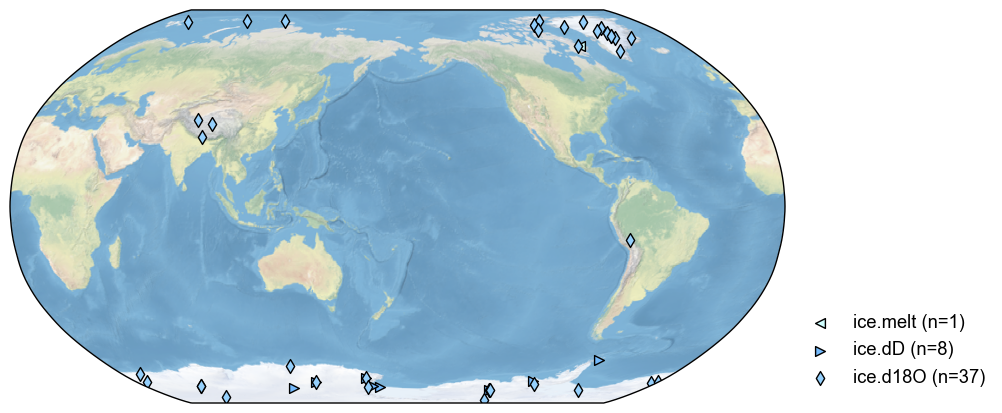

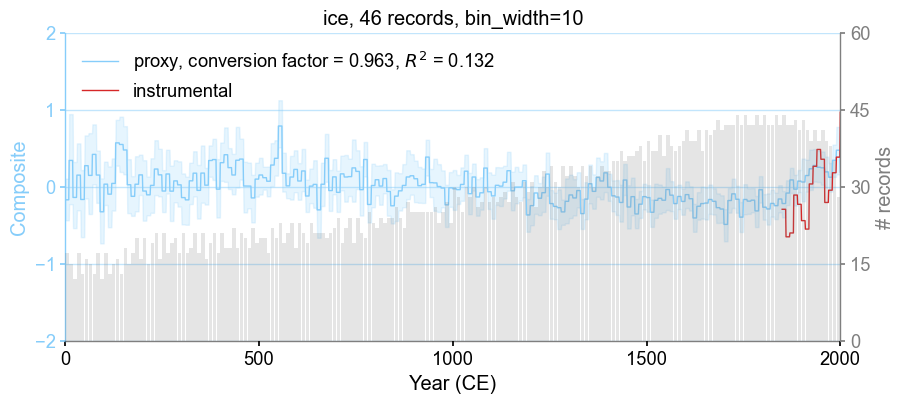

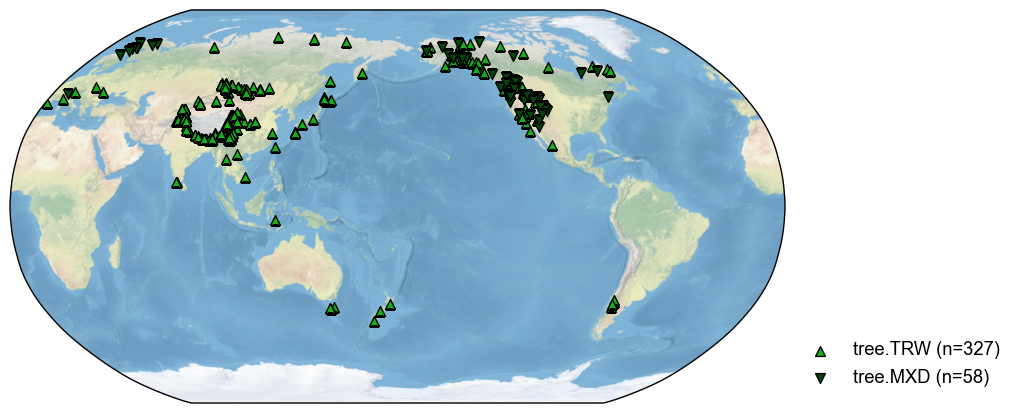

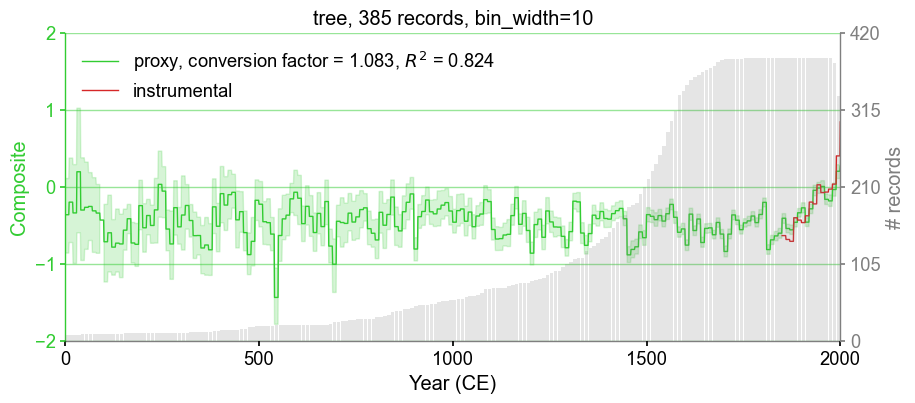

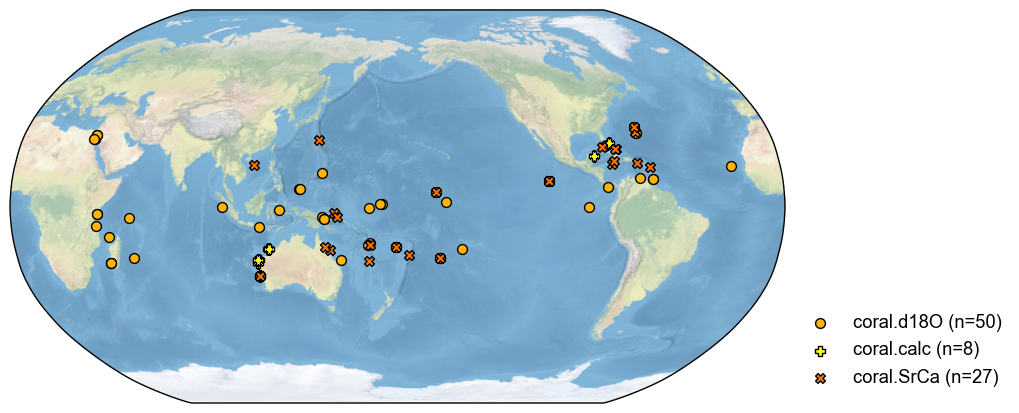

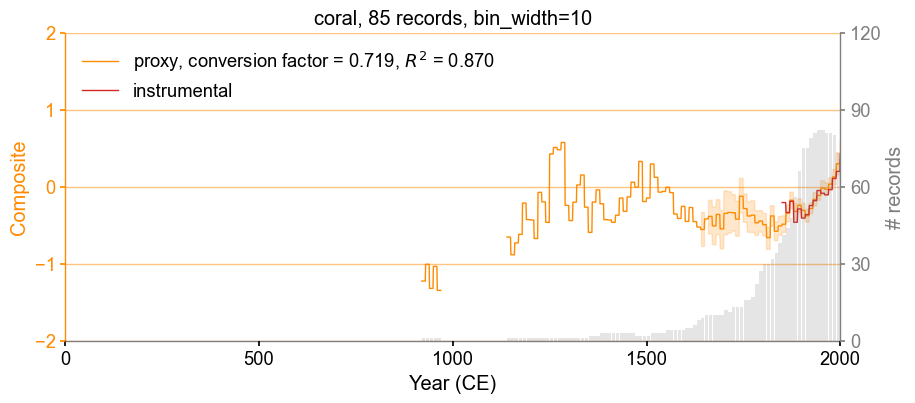

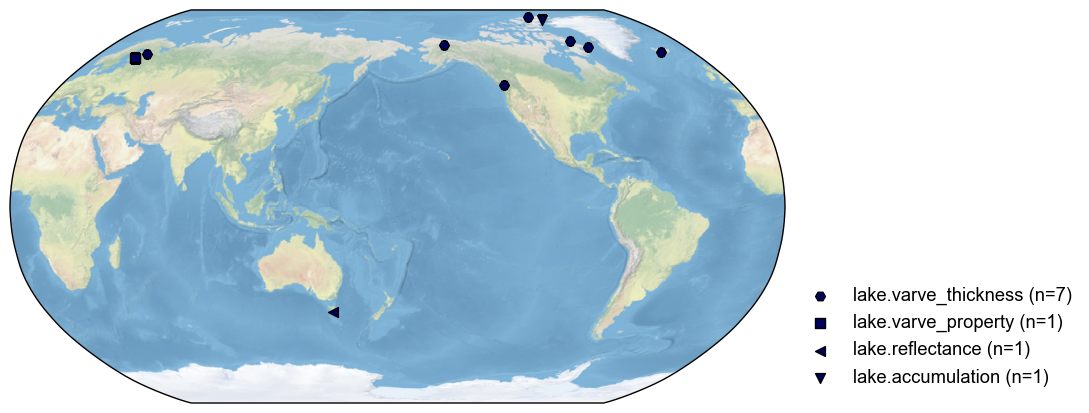

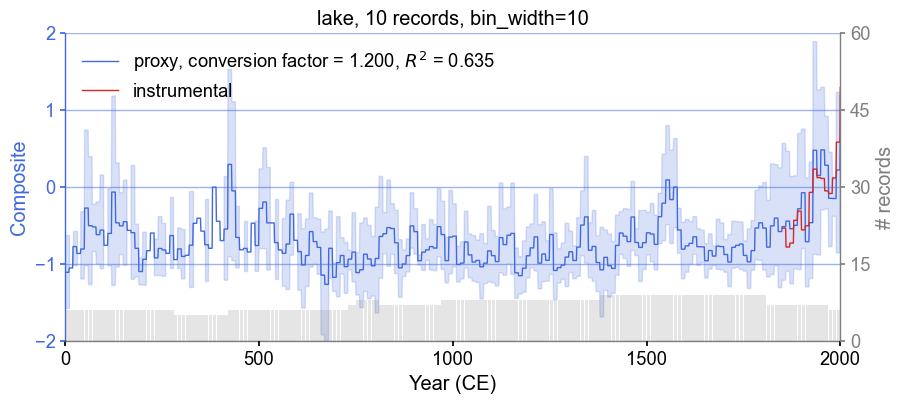

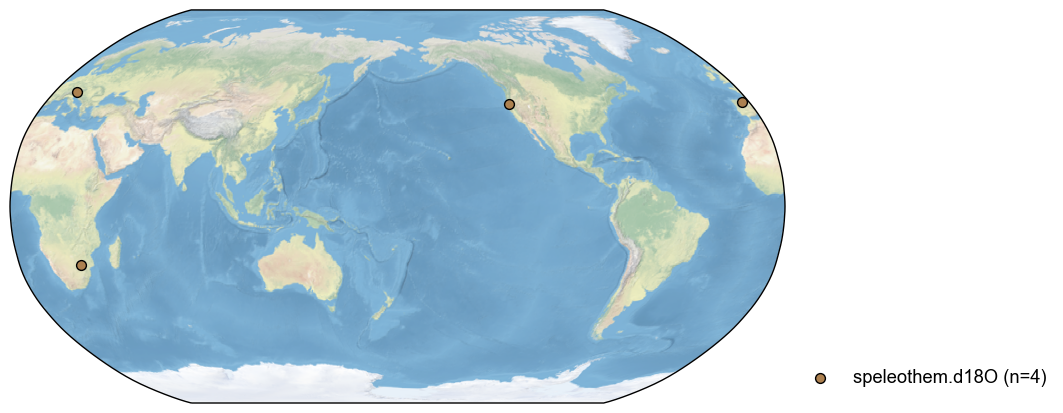

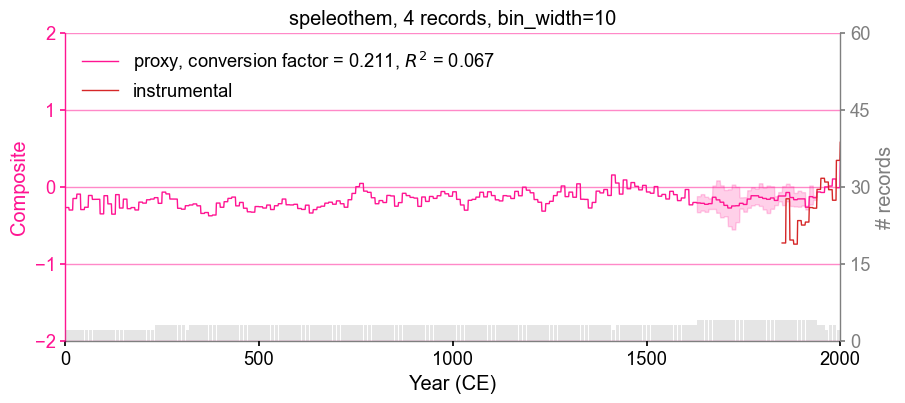

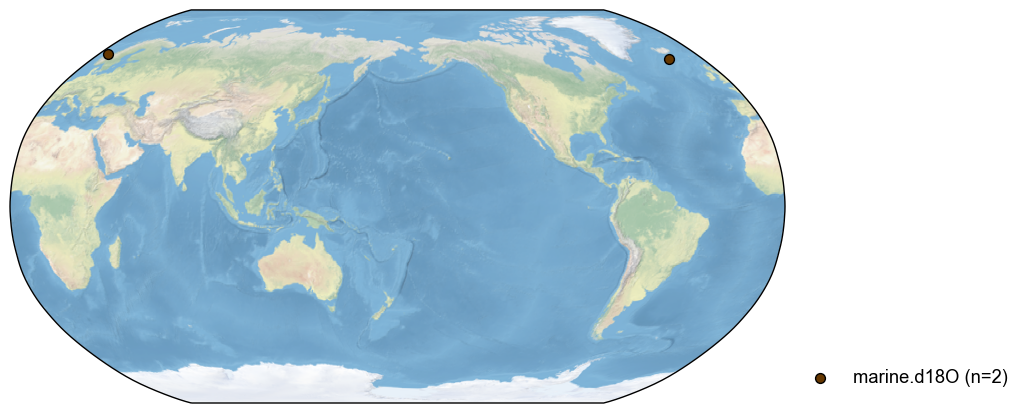

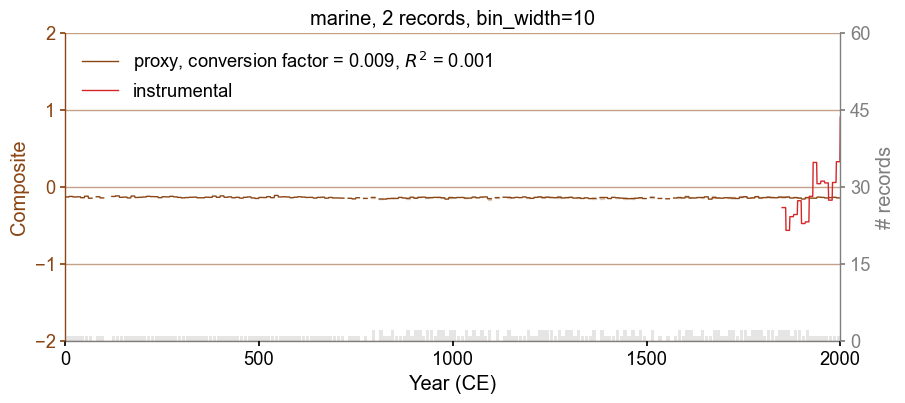

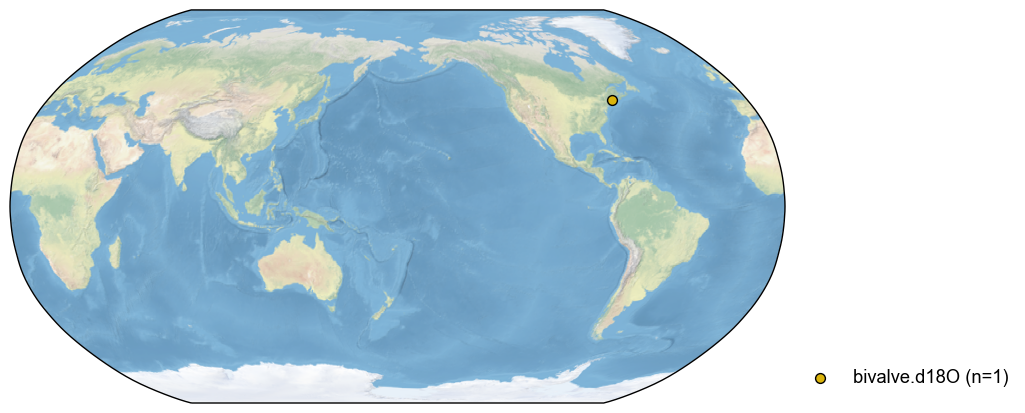

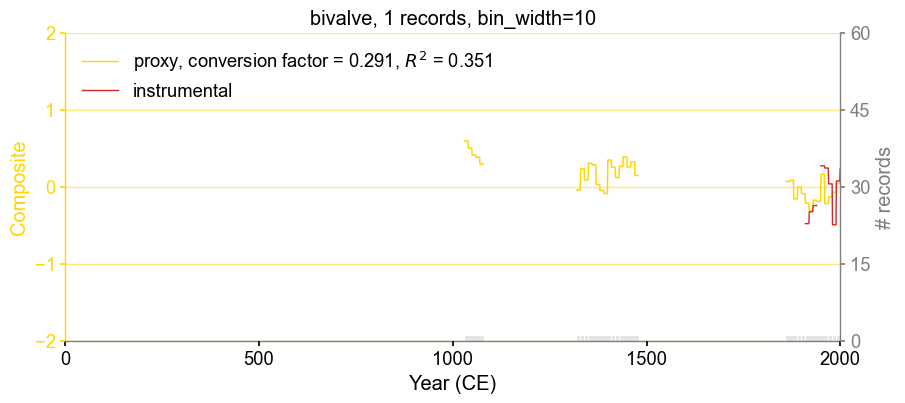

In [21]:
for item in proxy_type:

    pdb_proxytype = pdb.filter(by='ptype', keys=item)
    fig, ax = pdb_proxytype.plot()

    pdb_proxytype.make_composite(obs=obs)
    fig, ax = pdb_proxytype.plot_composite()

##### Reconstruction with all the records

Analyzing ProxyRecord:   6%|█▏                 | 32/533 [00:00<00:10, 49.44it/s]/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Analyzing ProxyRecord:  16%|███                | 86/533 [00:01<00:09, 48.81it/s]/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/lib/function_b

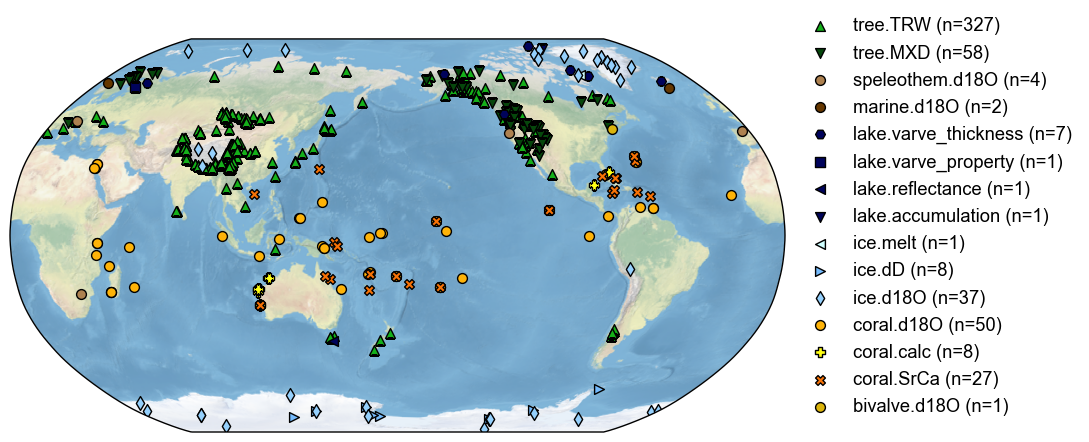

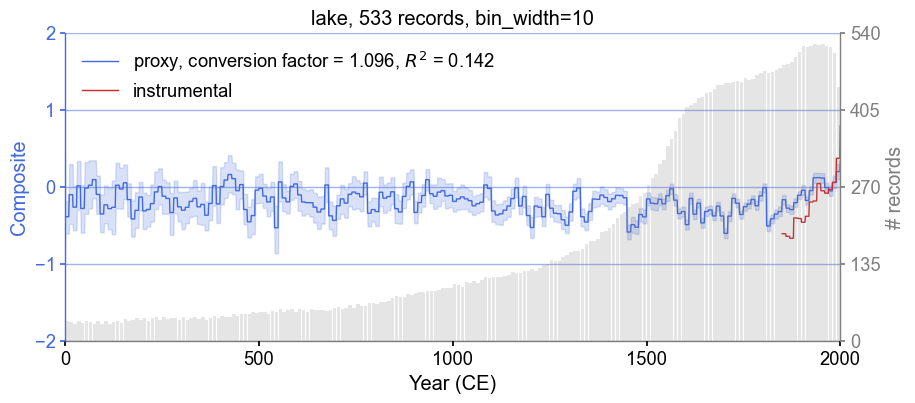

In [23]:
fig, ax = pdb.plot()

pdb.make_composite(obs=obs)
fig, ax = pdb.plot_composite()

#### Create a composite without an instrumental target

Analyzing ProxyRecord:   0%|                             | 0/33 [00:00<?, ?it/s]/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/deborahkhider/opt/anaconda3/envs/cfr/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims

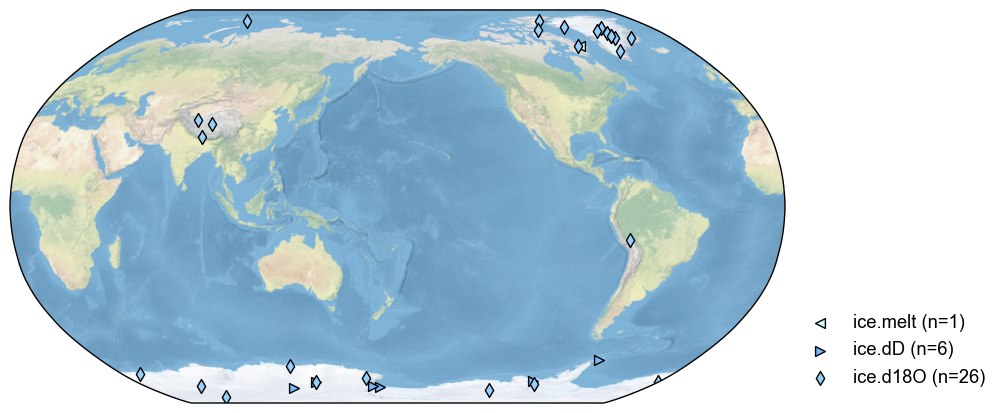

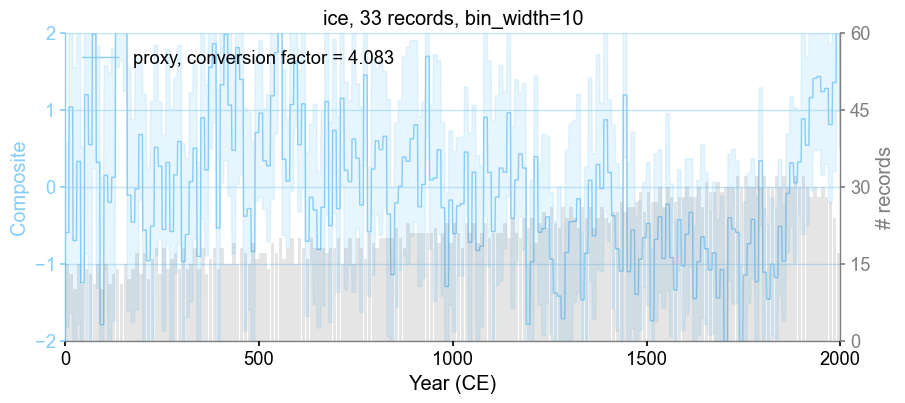

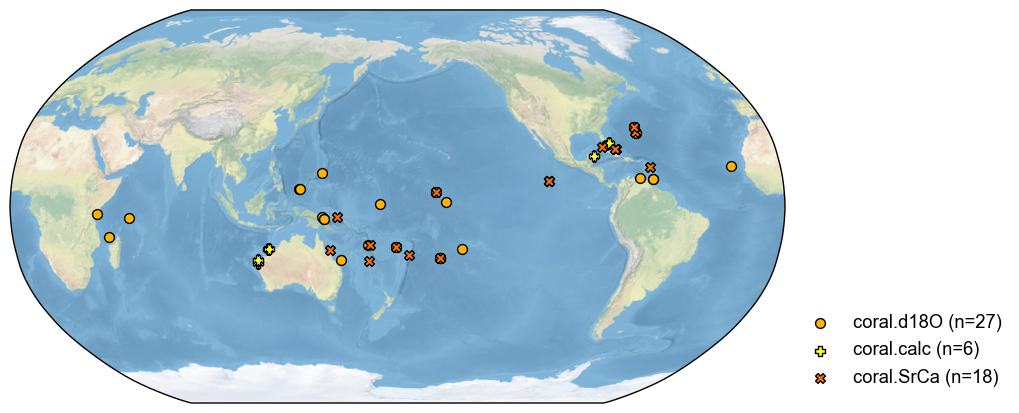

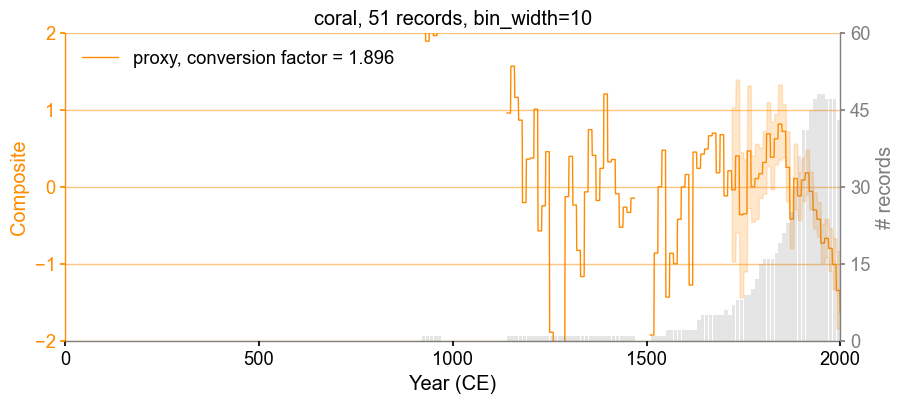

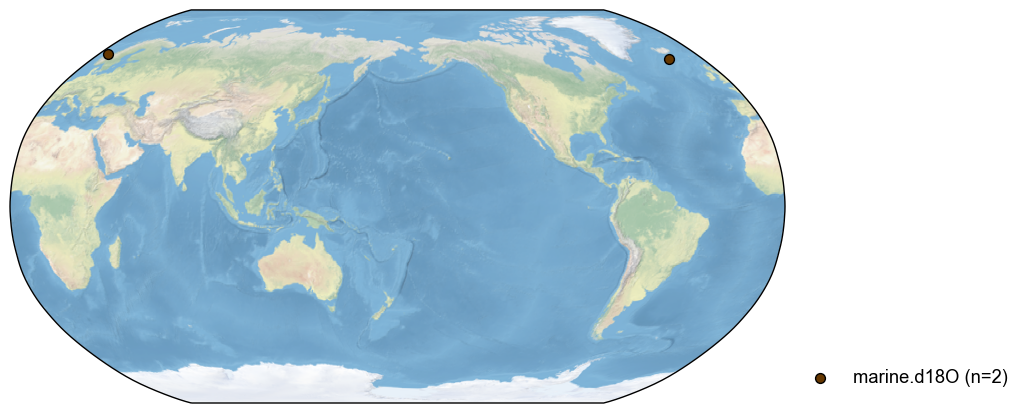

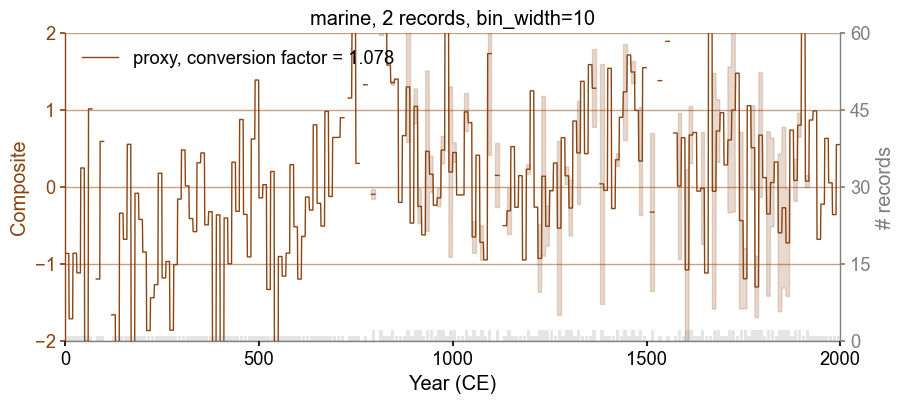

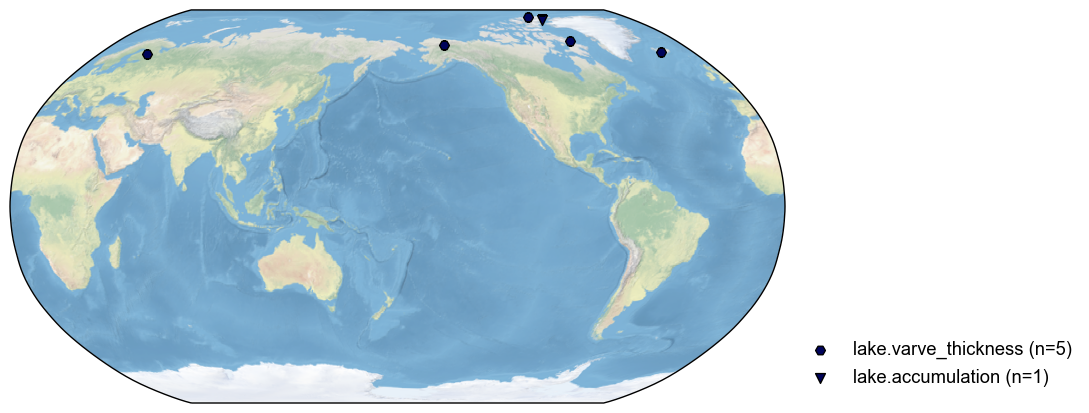

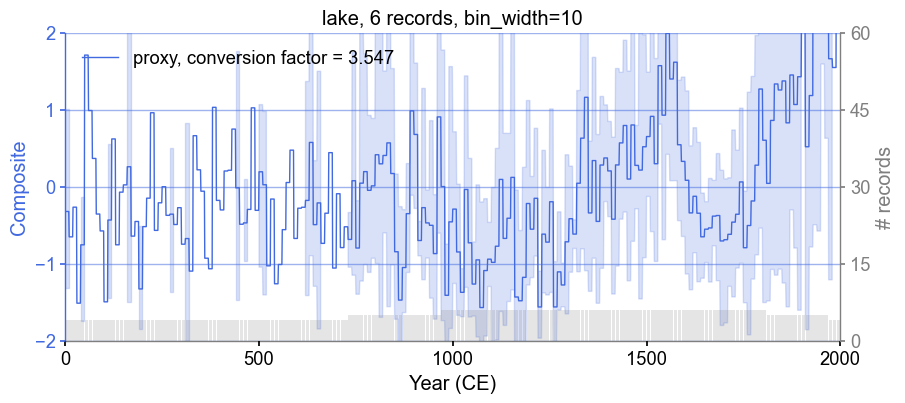

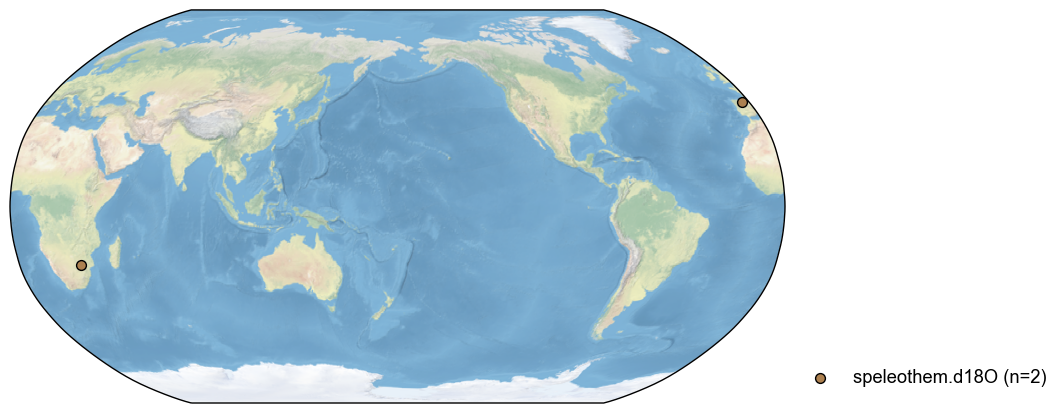

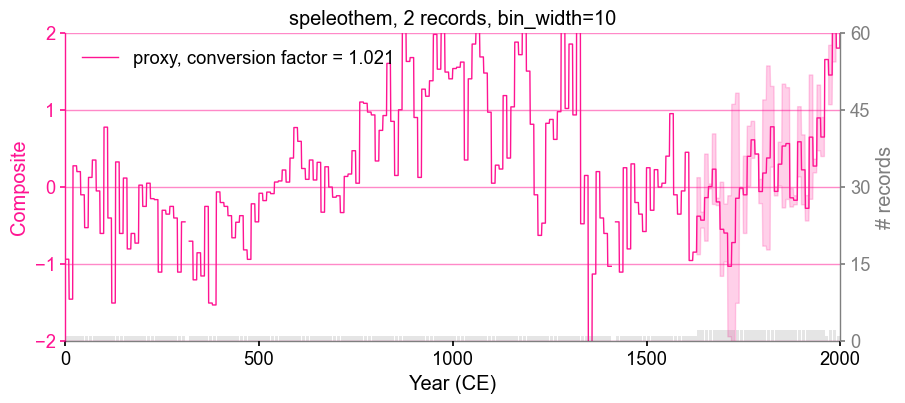

In [8]:
for item in proxy_type:

    pdb_proxytype = pdb.filter(by='ptype', keys=item)
    fig, ax = pdb_proxytype.plot()

    pdb_proxytype.make_composite(bin_width=10)
    fig, ax = pdb_proxytype.plot_composite()

## Iso2k database

### Query the GraphDB for the temperature sensitive timeseries from ISO2k

In [ ]:
url = 'https://linkedearth.graphdb.mint.isi.edu/repositories/LiPDVerse'

query = """PREFIX le: <http://linked.earth/ontology#>
select ?dsname ?val ?timeval ?archive ?pages2kID ?timeunits ?varname ?varunits ?lat ?lon ?alt ?proxysensor ?proxyobs ?timevarname FROM <http://linked.earth/lipd/Pages2k2_1_2> where { 
	VALUES ?timevarname {"year" "age"}
    ?ds  le:includesPaleoData ?data .
    ?ds le:name ?dsname .
    ?ds le:hasUrl ?url .
    ?ds  le:collectedFrom ?loc .
    ?loc le:wgs84_Lat ?lat .
    ?loc le:wgs84_Long ?lon .
    ?loc le:wgs84_Alt ?alt .
	?data le:foundInMeasurementTable ?table .
	?table le:includesVariable ?var .
    ?var le:useInGlobalTemperatureAnalysis true .
    ?var le:hasValues ?val .
    ?var le:name ?varname . 
    ?var le:hasUnits ?varunits .
    ?table le:includesVariable ?timevar .
    ?timevar le:name ?timevarname .
    ?timevar le:hasValues ?timeval .
    ?ds le:proxyArchiveType ?archive .
    ?timevar le:hasUnits ?timeunits .
    ?var le:hasProxySystem ?proxysystem .
    ?proxysystem le:proxySensorType ?proxysensor .
    ?proxysystem le:proxyObservationType ?proxyobs .
    ?var le:pages2kID ?pages2kID .
}"""


response = requests.post(url, data = {'query': query})
data = io.StringIO(response.text)
df = pd.read_csv(data, sep=",")

# Make list from the values string
df['val']=df['val'].apply(lambda row : ast.literal_eval(row))
df['timeval']=df['timeval'].apply(lambda row : ast.literal_eval(row))

df.head()

## Temp12k Database

### Query the GraphDB for the temperature sensitive timeseries